In [1]:
# conda activate sfmr
import os
import __init__ as f
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import CRS, Geod
import glob
from tqdm import tqdm
from pathlib import Path

In [2]:
### PATHS
PTHS = {
    'sat_dir':        '/home/arthur/data/**/KNMI/product_JF_rotated_filtered/POLAR/',
    'sfm_dir_noaa':   '/home/arthur/data/cyclobs/sfmr/noaa_aoml_hrd/',  
    'sfm_dir_nesdis': '/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/',
    'sav_dir':        '/home/arthur/data/cyclobs/sfmr/colloc_sfmr_radScat/'
}

### PARAMS
PRMS = {
    'delta_t': 120, # SFMR data will be cropped around +/- 120min around the satellite acquisition
    'r_ref':   np.linspace(0, 800000, 801), # Ref. grid
    'save':    False
}

In [3]:
# # SFMR
# p_sfmr  = '/home/arthur/data/cyclobs/sfmr/noaa_aoml_hrd/2019/dorian/AFRC_SFMR20190830U3.nc'
# ds_sfmr = xr.open_dataset(p_sfmr)
# ds_sfmr = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
# print('Time interval: ', ds_sfmr.attrs['TimeInterval'])

In [4]:
# # SCAT or RAD
# p_sct  = '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered/POLAR/2019/AL052019/POL_ascat_20190831_013900_metopb_36063_srv_o_125_ovw.nc'
# ds_sct = xr.open_dataset(p_sct)
# P_SCT  = '/home/arthur/data/scatterometer/KNMI/product_JF/' + ds_sct.data_file.item()
# DS_SCT = xr.open_dataset(P_SCT)

In [5]:
# p = '/home/arthur/data/radiometer/KNMI/product_JF_rotated_filtered/POLAR/2019/AL052019/POL_SM_REPR_MIR_SCNFSW_20190904T100421_20190904T105819_300_301_7.nc'
# a = xr.open_dataset(p)

In [6]:
def preprocess_time(t):
    if len(t) == 5:
        return '0' + t
    else:
        return t

def get_mission(pth):
    return pth.split('/')[6]

def get_var_names(pth):
    if get_mission(pth) == 'noaa_aoml_hrd':
        return ['LON', 'LAT', 'SWS']
    if get_mission(pth) == 'noaa_nesdis_star':
        return ['longitude', 'latitude', 'wind_speed']
    
def preprocess_sfmr(pth):
    # Open SFMR & get start/end dates
    if get_mission(pth) == 'noaa_aoml_hrd':
        subset    = ['DATE', 'TIME', 'LON', 'LAT', 'SWS']
        ds_sfmr   = xr.open_dataset(pth)[subset]
        ds_sfmr   = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
        sttDate   = ds_sfmr.DATE[0].astype(str).item()[:8]
        endDate   = ds_sfmr.DATE[-1].astype(str).item()[:8]
    if get_mission(pth) == 'noaa_nesdis_star':
        subset    = ['time', 'longitude', 'latitude', 'wind_speed']
        ds_sfmr   = xr.open_dataset(pth)[subset] 
        sttDate   = '{}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).year,  pd.to_datetime(ds_sfmr.time[0].data).month,  pd.to_datetime(ds_sfmr.time[0].data).day)
        endDate   = '{}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).year, pd.to_datetime(ds_sfmr.time[-1].data).month, pd.to_datetime(ds_sfmr.time[-1].data).day)
        
    # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
    sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
    sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
    sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
    sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
    sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
    sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
    sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates

    # Start dateTime of SFMR
    if get_mission(pth) == 'noaa_aoml_hrd':
        sttTime, endTime =  preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])
    if get_mission(pth) == 'noaa_nesdis_star':    
        sttTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[0].data).hour,  pd.to_datetime(ds_sfmr.time[0].data).minute,  pd.to_datetime(ds_sfmr.time[0].data).second)
        endTime = '{:02d}{:02d}{:02d}'.format(pd.to_datetime(ds_sfmr.time[-1].data).hour, pd.to_datetime(ds_sfmr.time[-1].data).minute, pd.to_datetime(ds_sfmr.time[-1].data).second)  
    dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
    dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
    dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
    dtt_sfmr_end     = np.datetime64(dtt_str_end)

    return ds_sfmr, sat_pths, dtt_sfmr_stt, dtt_sfmr_end

In [7]:
# ds_sfmr = xr.open_dataset(sfm_pths[0])[['time', 'longitude', 'latitude', 'wind_speed']]

# # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
# sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
# sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
# sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
# sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
# sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
# sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
# sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates

# # Start dateTime of SFMR

# # dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
# # dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
# # dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
# # dtt_sfmr_end     = np.datetime64(dtt_str_end)

  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]INFO:coloc_config.py:/home/arthur/data/cyclobs/sfmr/noaa_nesdis_star/1.2.0/2018/SFMR180914H1-level2.nc
INFO:coloc_config.py:timing sfmr_resample : 0.0s. mem: +0.0Mb
INFO:coloc_config.py:timing spatial_downsample : 2.9s. mem: +34.7Mb
INFO:coloc_config.py:timing sfmr_translate : 0.2s. mem: +22.1Mb


0


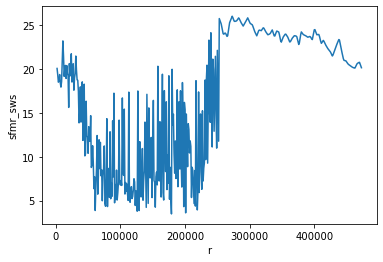


1it [00:03,  3.30s/it]
100%|██████████| 1/1 [00:10<00:00, 10.79s/it]


In [8]:
sfm_pths_noaa   = glob.glob(PTHS['sfm_dir_noaa'] + '**/*.nc', recursive=True)
sfm_pths_nesdis = glob.glob(PTHS['sfm_dir_nesdis'] + '**/*.nc', recursive=True)
sfm_pths        = sfm_pths_nesdis + sfm_pths_noaa # Reverse order once debugged
# subset          = ['DATE', 'TIME', 'LON', 'LAT', 'SWS']

for sfm_pth in tqdm(sfm_pths):
#     ds_sfmr = xr.open_dataset(sfm_pth)[subset]
#     ds_sfmr = ds_sfmr.where(ds_sfmr.SWS >= 0, drop=True) # SFMR SWS contains NaN values (labelled -999.9)
#     sttDate = ds_sfmr.DATE[0].astype(str).item()[:8]
#     endDate = ds_sfmr.DATE[-1].astype(str).item()[:8]
#     # Find satellite paths based on start and end dates of flight, and then concatenate (without duplicate values)
#     sat_pths1 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(sttDate[:4], sttDate), recursive=True)
#     sat_pths2 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}*.nc'.format(endDate[:4], endDate), recursive=True)
#     sat_pths3 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
#     sat_pths4 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}-{}-{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
#     sat_pths5 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(sttDate[:4], sttDate[:4], sttDate[4:6], sttDate[6:8]), recursive=True)
#     sat_pths6 = glob.glob(PTHS['sat_dir'] + '{}/**/*_{}_{}_{}*.nc'.format(endDate[:4], endDate[:4], endDate[4:6], endDate[6:8]), recursive=True)
#     sat_pths  = sorted(list(set(sat_pths1 + sat_pths2 + sat_pths3 + sat_pths4 + sat_pths5 + sat_pths6))) # remove duplicates
    
#     # Start dateTime of SFMR
#     sttTime, endTime =  preprocess_time(ds_sfmr.TIME[0].astype(str).item()[:-2]), preprocess_time(ds_sfmr.TIME[-1].astype(str).item()[:-2])
#     dtt_str_stt      = '{}-{}-{}T{}:{}:{}'.format(sttDate[:4], sttDate[4:6], sttDate[6:], sttTime[:2], sttTime[2:4], sttTime[4:6])
#     dtt_str_end      = '{}-{}-{}T{}:{}:{}'.format(endDate[:4], endDate[4:6], endDate[6:], endTime[:2], endTime[2:4], endTime[4:6])
#     dtt_sfmr_stt     = np.datetime64(dtt_str_stt)
#     dtt_sfmr_end     = np.datetime64(dtt_str_end)

    ds_sfmr, sat_pths, dtt_sfmr_stt, dtt_sfmr_end = preprocess_sfmr(sfm_pth)
    sfm_lon, sfm_lat, sfm_sws                     = get_var_names(sfm_pth)
    
    # Iterate over all candidates satellite files
    for i, sat_pth in tqdm(enumerate(sat_pths)):
        ds_sat = xr.open_dataset(sat_pth)
        dt_sfm_sat_stt = (ds_sat.acquisition_time - dtt_sfmr_stt) / np.timedelta64(1, 's') # Time diff. SAT - SFMR_START
        dt_sfm_sat_end = (ds_sat.acquisition_time - dtt_sfmr_end) / np.timedelta64(1, 's') # Time diff. SAT - SFMR_END
        if (dt_sfm_sat_stt >= 0) & (dt_sfm_sat_end <= 0): # SAT. acq. time must be in between
            if (abs(((ds_sfmr[sfm_lon] % 360).mean(skipna=True) - ds_sat.lon_IBT)) <= 10) & (abs(((ds_sfmr[sfm_lat]).mean(skipna=True) - ds_sat.lat_IBT)) <= 10): # check also that it's the same storm (lon, lat)
                # Open Jeff's IBTrACS product (MAXSS version)
                DS_SAT = xr.open_dataset('/'.join(sat_pth.split('/')[:6]) + '/product_JF/' + ds_sat.data_file.item())
                track_df = pd.DataFrame(
                    data={
                        'datetime': DS_SAT.track_time,
                        'lon':      DS_SAT.__track_lon,
                        'lat':      DS_SAT.__track_lat,
                    }
                )
                # Get acquisition time
                acq_time = ds_sat.acquisition_time.values
                acq_time = pd.to_datetime(acq_time.astype('datetime64[s]')) # round to nearest second and convert to datetime object

                # Put SFMR points on satellite points, accounting for storm translation
                sfmr_df  = f.prepare_sfmr(sfm_pth, track_df, acq_time)
                dss      = sfmr_df.to_xarray()
                # Cropping at +/- 2hrs from satellite acquisition time
                dss      = dss.where(abs((ds_sat.acquisition_time.values - dss.time) / np.timedelta64(1, 'm')) <= PRMS['delta_t'], drop=True)

                # TODO: handle lon, lat 
                dss[sfm_lon] = dss[sfm_lon] % 360

                ### Get (r, theta) of SFMR from TC center 
                # Convert (lon_center, lat_center) to array 
                lons_center = np.ones_like(dss[sfm_lon]) * float(ds_sat.lon_IBT)
                lats_center = np.ones_like(dss[sfm_lat]) * float(ds_sat.lat_IBT)
                # Get the distance between target point and center point
                geod_wgs84  = CRS("epsg:4326").get_geod()
                _, _, dr    = geod_wgs84.inv(lons_center, lats_center, dss[sfm_lon], dss[sfm_lat])
                # Change dss dim/coordinates
                dss['time'] = dr
                dss         = dss.rename_dims({'time': 'dr'}).rename({'time': 'dr'})
                dss         = dss.interp({'dr': PRMS['r_ref']})

                # Save
                ds_col = xr.Dataset(
                    data_vars={
                        'sfmr_sws':         ('r', dss[sfm_sws].data),
                        'vmx_IBT':          ds_sat.vmx_IBT.data,
                        'rmx_IBT':          ds_sat.rmx_IBT.data,
                        'r34_IBT':          ds_sat.r34_IBT.data,
                        'r50_IBT':          ds_sat.r50_IBT.data,
                        'r64_IBT':          ds_sat.r64_IBT.data,
                        'lon_IBT':          ds_sat.lon_IBT.data,
                        'lat_IBT':          ds_sat.lat_IBT.data,
                        'storm_dir_IBT':    ds_sat.storm_dir_IBT.data,
                        'storm_speed_IBT':  ds_sat.storm_speed_IBT.data,
                        'atcf_id':          ds_sat.atcf_id.data,
                        'sat_acq_time':     ds_sat.acquisition_time.data,
                        'sat_file':         ds_sat.data_file.data,
                        'sat_mission':      ds_sat.mission.data,
                    },
                    coords={
                        'r': PRMS['r_ref']
                    }
                )
                
                # print(i)
                # ds_col.sfmr_sws.plot();plt.show()
                
                if PRMS['save']:
                    atcf_id = ds_sat.atcf_id.item()
                    # print(atcf_id)
                    # if atcf_id == 'AL132018':
                    #     break
                    p_sav   = Path(PTHS['sav_dir'] + '{}/{}/'.format(atcf_id[-4:], atcf_id))
                    p_sav.mkdir(parents=True, exist_ok=True)
                    ds_col.to_netcdf(PTHS['sav_dir'] + '{}/{}/{}_{}'.format(atcf_id[-4:], atcf_id, os.path.basename(sfm_pth)[:-3], os.path.basename(sat_pth)))
                    # ds_col.to_netcdf(PTHS['sav_dir'] + '{}_{}'.format(os.path.basename(sfm_pth)[:-3], os.path.basename(sat_pth)))

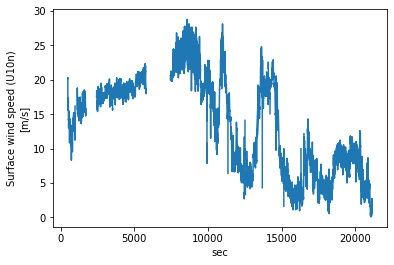

In [17]:
ds_sfmr.wind_speed.plot()

In [19]:
a = xr.open_dataset(sfm_pth)

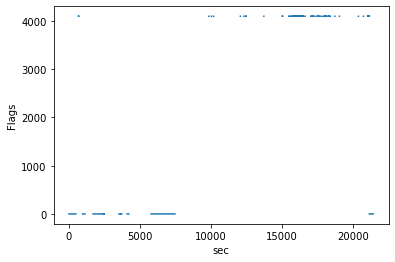

In [26]:
a.flags.plot()

In [25]:
a.quality

<xarray.DataArray 'quality' (sec: 21404)>
array([3., 3., 3., ..., 3., 3., 3.], dtype=float32)
Dimensions without coordinates: sec
Attributes:
    standard_name:  wind_speed rainfall_rate status_flag
    long_name:      Retrieval quality flag
    valid_range:    [0 1 2 3]
    flag_values:    [0 1 2 3]
    flag_meanings:  valid\nquestionable\ninvalid\nno_retrieval_solution

In [12]:
ds_sat

<xarray.Dataset>
Dimensions:           (theta: 361, rad: 41)
Coordinates:
  * theta             (theta) float64 0.0 1.0 2.0 3.0 ... 358.0 359.0 360.0
  * rad               (rad) float64 0.0 25.0 50.0 75.0 ... 950.0 975.0 1e+03
Data variables: (12/14)
    wind_speed        (theta, rad) float64 19.25 16.02 10.93 ... 5.522 5.598
    vmx_IBT           float64 18.0
    rmx_IBT           float64 74.27
    r34_IBT           float64 92.6
    r50_IBT           float64 nan
    r64_IBT           float64 nan
    ...                ...
    storm_dir_IBT     float64 274.0
    storm_speed_IBT   float64 7.202
    atcf_id           <U8 'AL092018'
    acquisition_time  datetime64[ns] 2018-09-14T17:56:43.654320987
    data_file         <U93 'amsr2/north-atlantic/2018/2018251N13325_AL092018_...
    mission           <U5 'amsr2'

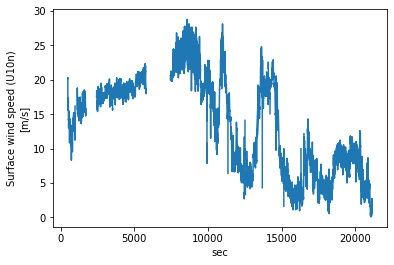

In [13]:
ds_sfmr.wind_speed.plot()

In [14]:
len(sat_pths)

47